#### This notebook describes:

#### 1) How the allmarkes gene table for Niche specific genes was calculated for figure 2 and coresponding supplementary figures

#### 2) How based on those DGE the functional enrichment for GO and MsigDB terms was calculated for figure 2 and coresponding supplementary figures

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors

#import scvi
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

plt.rcParams['figure.figsize'] = (6, 6)

from IPython.core.display import display, HTML
import random

#Define a colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
#colorsComb = np.vstack([colors3, colors2])
#mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Helper function to split list in chunks
def chunks(lista, n):
    for i in range(0, len(lista), n):
        yield lista[i:i + n]
        
        plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)
def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)
sc.settings.figdir = "./figures/"

In [3]:
## frequently used variables
from matplotlib import colors
import matplotlib.pyplot as plt
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Along these Lines, a colourmap diverging from gray to red
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

## Some more Colour Maps
gray_violet = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "mediumvioletred", "indigo"], N = 128)
gray_blue = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "cornflowerblue", "darkblue"], N = 128)


def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
#plt.rcParams['figure.figsize'] = (6, 5)
#sc.set_figure_params(dpi=120, vector_friendly=True)

In [4]:
import matplotlib.colors as colors
c_low = colors.colorConverter.to_rgba('orange', alpha = 0)
c_high = colors.colorConverter.to_rgba('red',alpha = 1)
cmap_transparent = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low, c_high], 512)

In [5]:
import matplotlib.colors as colors
c_low2 = colors.colorConverter.to_rgba('green', alpha = 0)
c_high2 = colors.colorConverter.to_rgba('darkblue',alpha = 1)
cmap_transparent2 = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low2, c_high2], 512)

In [7]:
print(f"squidpy=={sq.__version__}")
print(f"scanpy=={sc.__version__}")

squidpy==1.2.3
scanpy==1.9.3


# load data

In [9]:
##load
adata_vis = sc.read(f".h5ad")

In [10]:
adata_vis

AnnData object with n_obs × n_vars = 57787 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden', 'leiden_15', 'leiden_2', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', '_indices', '_scvi_batch', '_scvi_labels', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Pericyte', 'S

In [23]:
cts = ['AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast',
       'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte',
       'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi',
       'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 
       'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 
       'Peribronchial fibroblast', 'Pericyte', 'Smooth Muscle', 'T cell', 'TB-SC', 'Vein', 'pDC', 'preTB-SC/RAS']

## all markers calculation

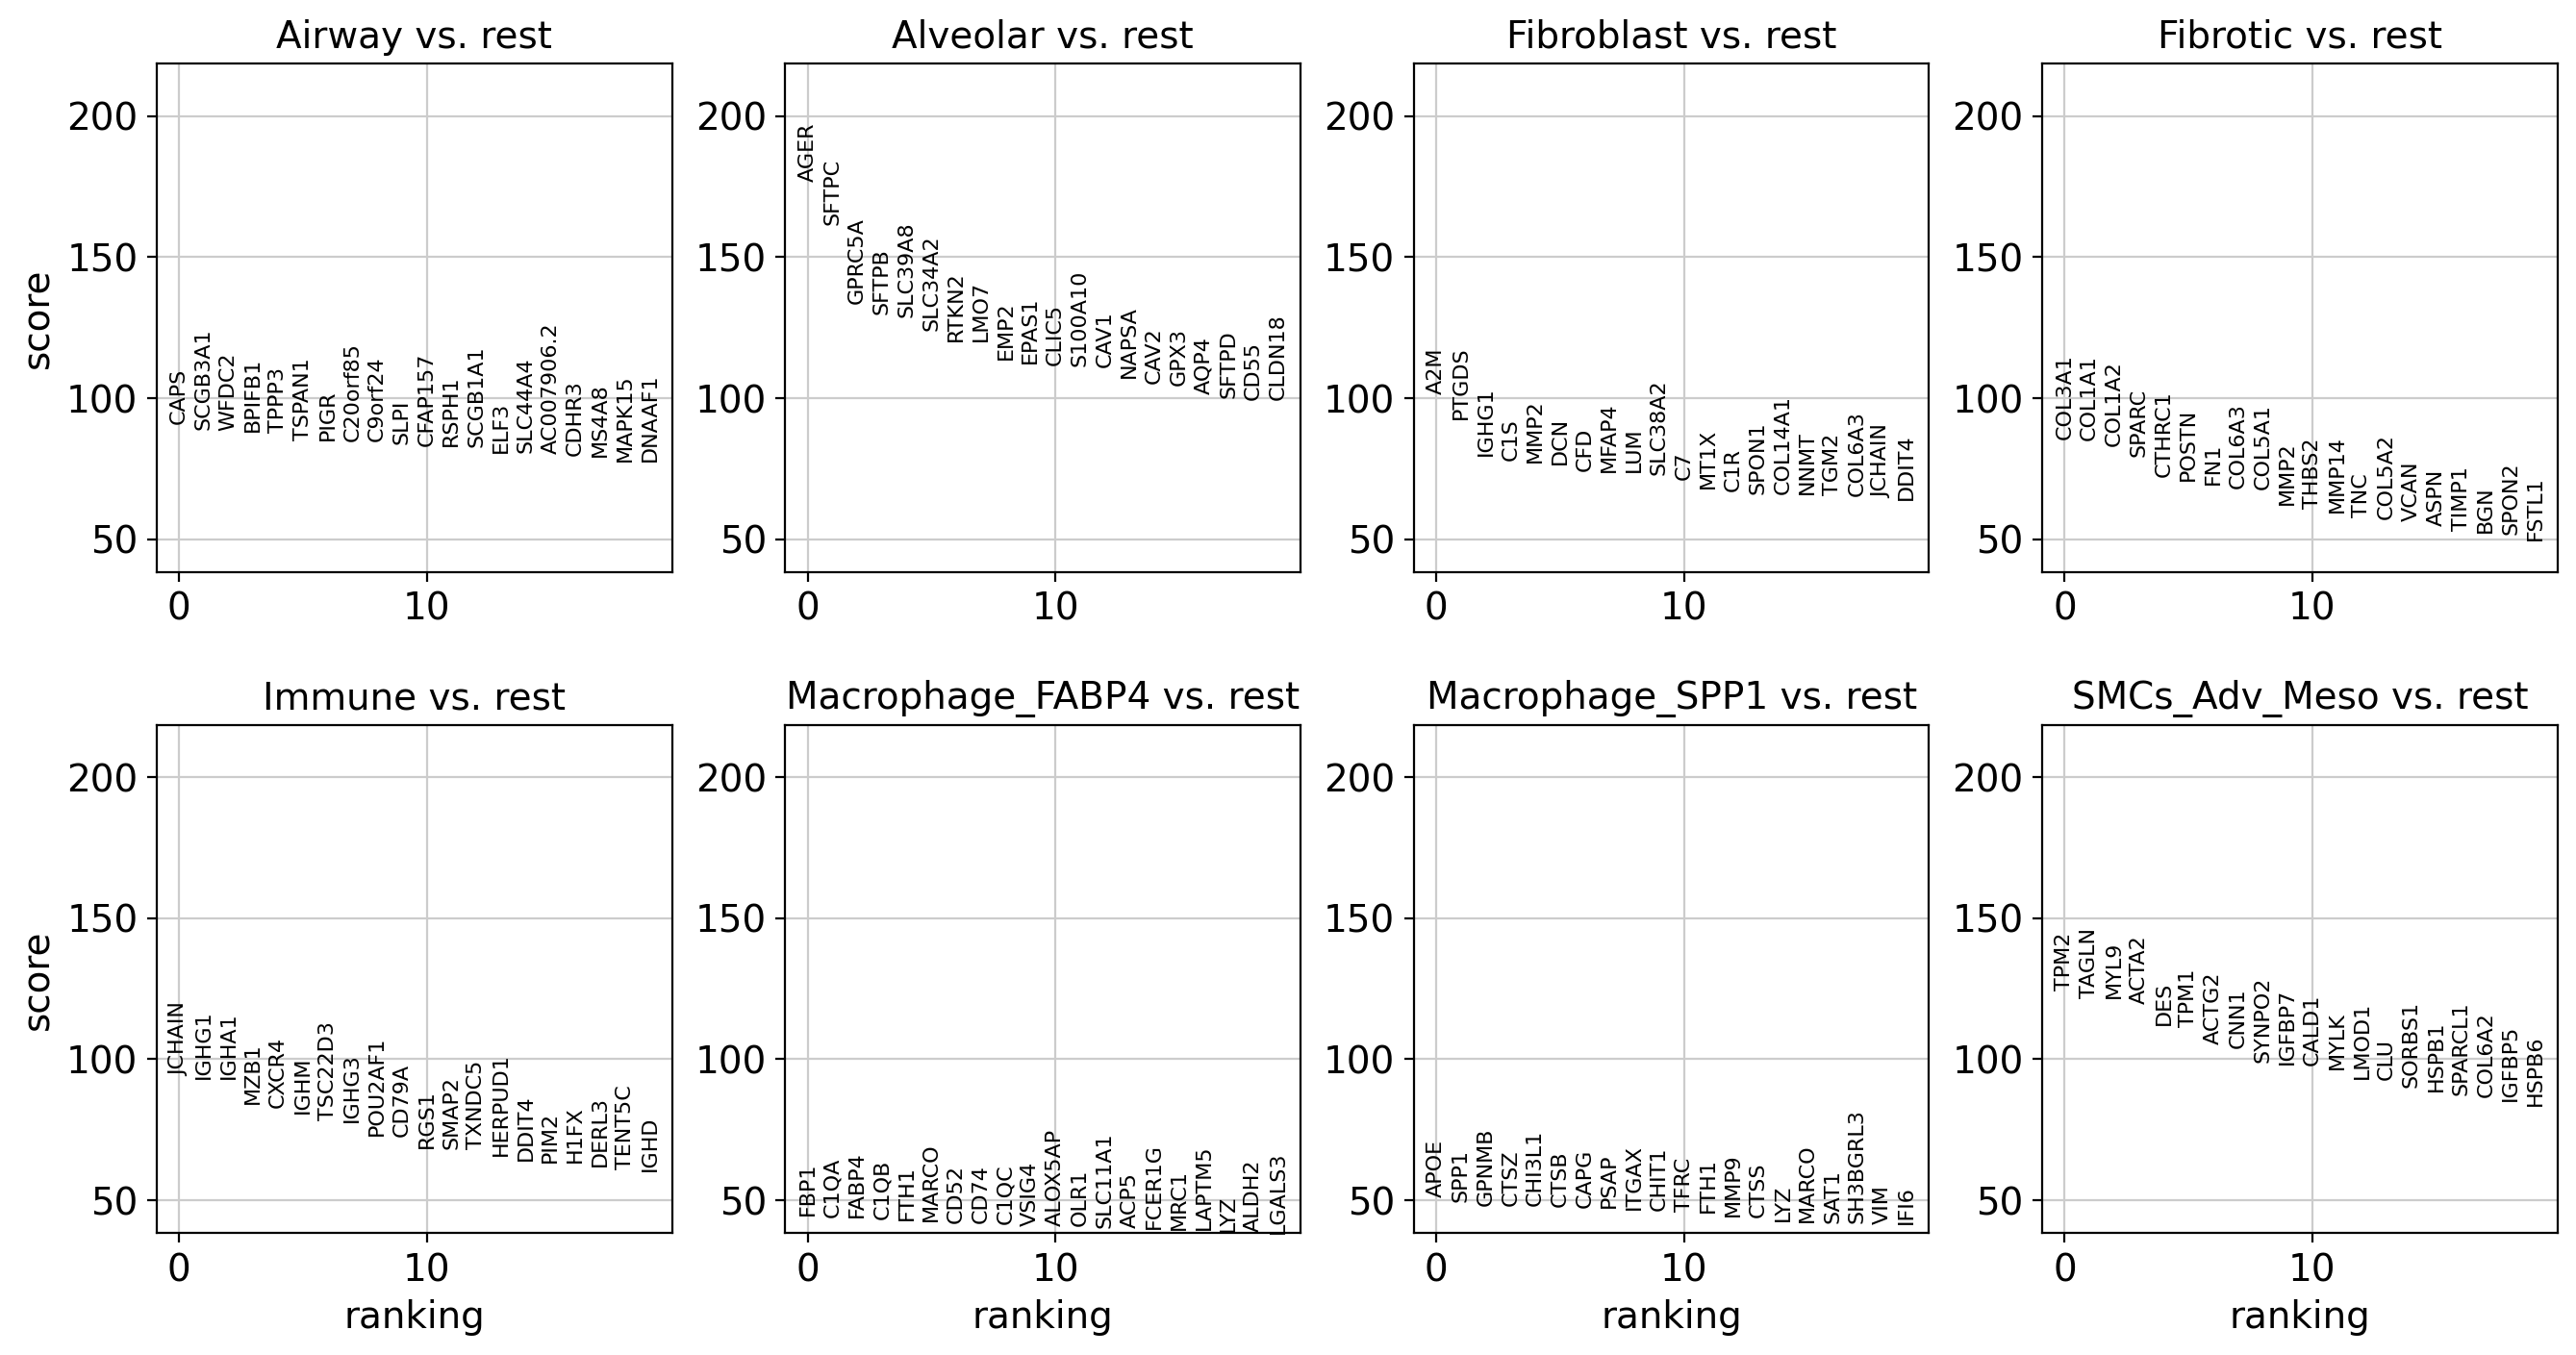

In [12]:
## All Markers
sc.tl.rank_genes_groups(adata_vis, groupby = 'Niche_NMF', groups = "all", use_raw = False, method = "wilcoxon", pts= True,)
sc.pl.rank_genes_groups(adata_vis)

In [13]:
## Combine into one Data Frame (comparable to Marker Table)
result = adata_vis.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
    current = pd.DataFrame({"gene": result["names"][cluster], "score": result["scores"][cluster],
                            "logfoldchange": result["logfoldchanges"][cluster], "pval": result["pvals"][cluster],
                            "pval_adj": result["pvals_adj"][cluster],
                            "pct_within":result["pts"].loc[result["names"][cluster]][cluster],
                            "pct_outside":result["pts_rest"].loc[result["names"][cluster]][cluster],  "cluster": cluster})
    allMarkers.append(current)
allMarkers = pd.concat(allMarkers)
allMarkers.head()

,gene,score,logfoldchange,pval,pval_adj,pct_within,pct_outside,cluster
CAPS,CAPS,90.806366,5.426556,0.0,0.0,0.985764,0.306026,Airway
SCGB3A1,SCGB3A1,88.781296,6.479405,0.0,0.0,0.991458,0.357705,Airway
WFDC2,WFDC2,88.547546,4.046841,0.0,0.0,0.988928,0.603998,Airway
BPIFB1,BPIFB1,88.092468,6.326958,0.0,0.0,0.963619,0.142807,Airway
TPPP3,TPPP3,87.837044,4.338563,0.0,0.0,0.981651,0.532823,Airway


In [29]:
## Write to file 
#folder =
allMarkers.to_csv("AllMarkers_human_Niche_NMF_CM.txt", sep = "\t", index = False)

In [30]:
allMarkers.head()

,gene,score,logfoldchange,pval,pval_adj,pct_within,pct_outside,cluster
CAPS,CAPS,90.806366,5.426556,0.0,0.0,0.985764,0.306026,Airway
SCGB3A1,SCGB3A1,88.781296,6.479405,0.0,0.0,0.991458,0.357705,Airway
WFDC2,WFDC2,88.547546,4.046841,0.0,0.0,0.988928,0.603998,Airway
BPIFB1,BPIFB1,88.092468,6.326958,0.0,0.0,0.963619,0.142807,Airway
TPPP3,TPPP3,87.837044,4.338563,0.0,0.0,0.981651,0.532823,Airway


In [14]:
allMarkers.drop("pval", axis=1, inplace=True)

In [15]:
allMarkers.head()

,gene,score,logfoldchange,pval_adj,pct_within,pct_outside,cluster
CAPS,CAPS,90.806366,5.426556,0.0,0.985764,0.306026,Airway
SCGB3A1,SCGB3A1,88.781296,6.479405,0.0,0.991458,0.357705,Airway
WFDC2,WFDC2,88.547546,4.046841,0.0,0.988928,0.603998,Airway
BPIFB1,BPIFB1,88.092468,6.326958,0.0,0.963619,0.142807,Airway
TPPP3,TPPP3,87.837044,4.338563,0.0,0.981651,0.532823,Airway


In [34]:
for i in adata_vis.obs.Niche_NMF.cat.categories:
    allMarkers_subset =allMarkers[allMarkers["cluster"]== i ]
    allMarkers_subset.to_csv("AllMarkers_human_Niche_NMF_%s.txt" %i, sep = "\t", index = False)

In [16]:
marker3 = allMarkers
marker3 = marker3[marker3['pct_outside'] < 0.25]
marker3 = marker3[marker3['pct_within'] > 0.25]
marker3 = marker3[marker3['logfoldchange'] > 1]
marker3

,gene,score,logfoldchange,pval_adj,pct_within,pct_outside,cluster
BPIFB1,BPIFB1,88.092468,6.326958,0.000000e+00,0.963619,0.142807,Airway
TSPAN1,TSPAN1,84.992714,5.191569,0.000000e+00,0.933882,0.151466,Airway
C20orf85,C20orf85,84.680817,6.041681,0.000000e+00,0.917115,0.081372,Airway
C9orf24,C9orf24,84.572067,5.964786,0.000000e+00,0.917748,0.089316,Airway
CFAP157,CFAP157,83.111435,5.883347,0.000000e+00,0.903828,0.077765,Airway
...,...,...,...,...,...,...,...
ITGB3,ITGB3,16.365520,1.106451,2.596847e-59,0.272583,0.171206,SMCs_Adv_Meso
P2RX1,P2RX1,16.338192,1.186257,4.049122e-59,0.287660,0.195476,SMCs_Adv_Meso
TEAD3,TEAD3,16.337582,1.003473,4.087323e-59,0.307499,0.217318,SMCs_Adv_Meso
PDLIM4,PDLIM4,16.086788,1.027810,2.358272e-57,0.289644,0.194242,SMCs_Adv_Meso


In [36]:
#Code zum filtern hast ja schon, die folgenden Zeilen wählen dann die top n gene per cluster aus (im gleichen ordering wie das dendrogram)
marker3.sort_values(by = ["cluster", "logfoldchange"], ascending = [True, False], inplace = True)

In [37]:
#Get ordering as in Dendrogram
sc.tl.dendrogram(adata_vis, groupby = "Niche_NMF")
order = adata_vis.uns["dendrogram_Niche_NMF"]["dendrogram_info"]["ivl"]

In [40]:
#Get top genes from Markers Table
n_genes = 10
genes = []
for typ in order:
    curgenes = marker3.loc[marker3.cluster == typ, "gene"].values[0:n_genes]
    genes = genes + [g for g in curgenes if g not in genes]

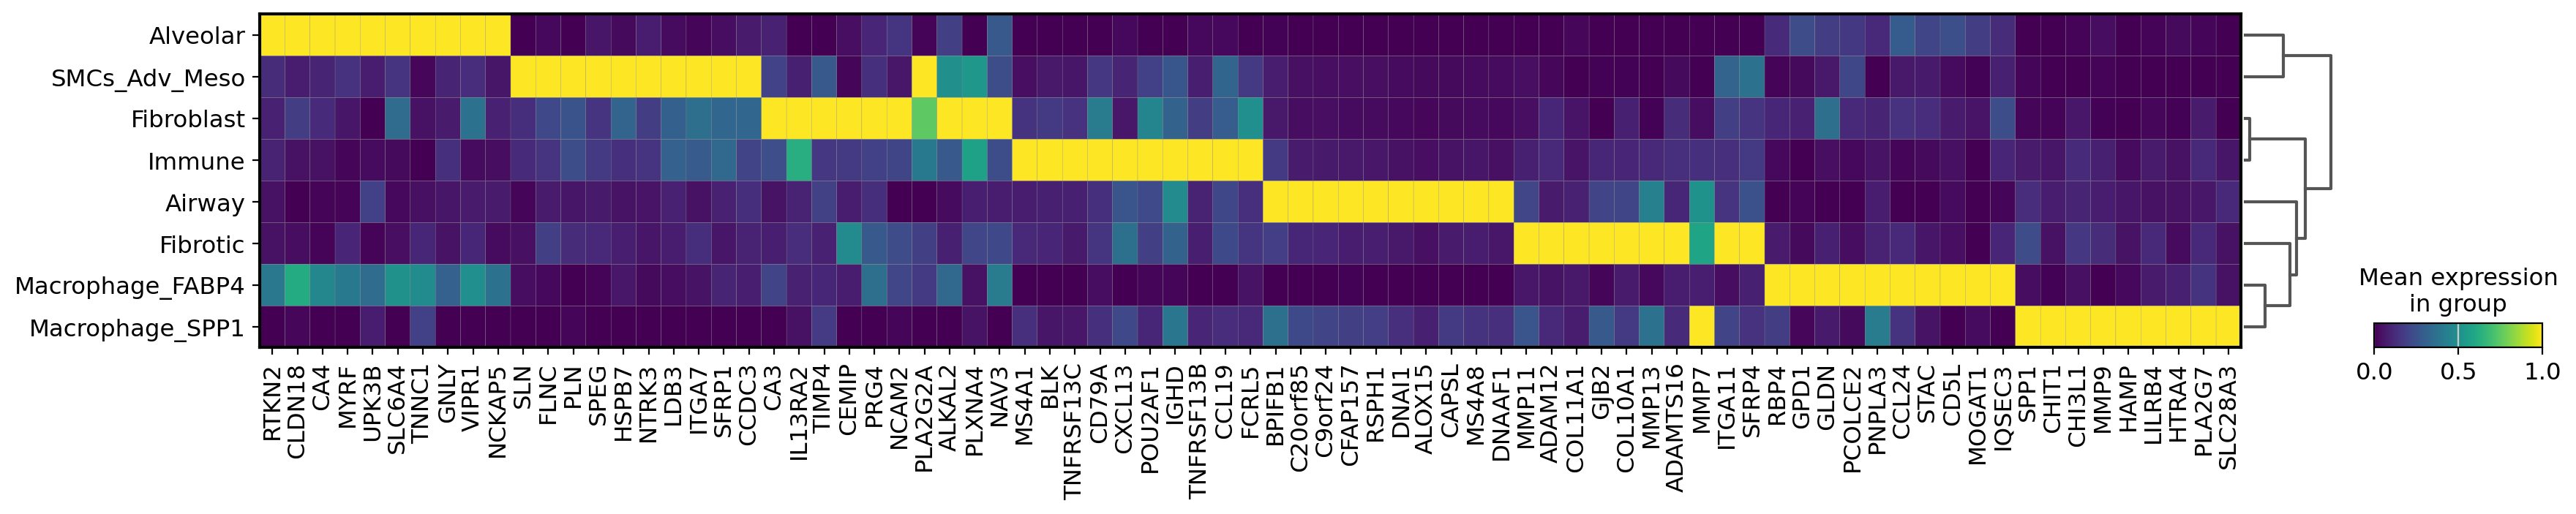

In [42]:
sc.pl.matrixplot(adata_vis, var_names = genes, standard_scale = "var", groupby = "Niche_NMF", dendrogram = True,figsize=(20,3),layer="log1p",
                save = "Allmarkers_matrixplottop%s_per_Niche_NMF_CM_025background_025celltype10logfc.pdf" %n_genes)

# gene set enrichment on DGe genes between Niche_NMF_CM

In [44]:
allMarkers =allMarkers[allMarkers["pval_adj"]<0.05]

In [45]:
allMarkers

,gene,score,logfoldchange,pval_adj,pct_within,pct_outside,cluster
CAPS,CAPS,90.806366,5.426556,0.0,0.985764,0.306026,Airway
SCGB3A1,SCGB3A1,88.781296,6.479405,0.0,0.991458,0.357705,Airway
WFDC2,WFDC2,88.547546,4.046841,0.0,0.988928,0.603998,Airway
BPIFB1,BPIFB1,88.092468,6.326958,0.0,0.963619,0.142807,Airway
TPPP3,TPPP3,87.837044,4.338563,0.0,0.981651,0.532823,Airway
...,...,...,...,...,...,...,...
GPRC5A,GPRC5A,-71.838211,-2.384515,0.0,0.314376,0.733564,SMCs_Adv_Meso
CD74,CD74,-72.283249,-1.040384,0.0,0.953842,0.989408,SMCs_Adv_Meso
AGER,AGER,-76.608734,-2.760643,0.0,0.366486,0.771792,SMCs_Adv_Meso
SLC34A2,SLC34A2,-77.929039,-2.144756,0.0,0.536172,0.878947,SMCs_Adv_Meso


In [17]:
import gseapy

In [18]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

## loop

In [332]:
allMarkers_subset =allMarkers[allMarkers["cluster"]== "Alveolar_AT1"]
allMarkers_subset =allMarkers_subset[allMarkers_subset["pval_adj"] < 0.05  ]
allMarkers_subset =allMarkers_subset[allMarkers_subset["logfoldchange"] > 0.5  ]
print(len(allMarkers_subset))

960


In [418]:
#?gseapy.enrichr
for i in adata_vis.obs.Niche_NMF.cat.categories:
    genelist = sc.get.rank_genes_groups_df(adata_vis, group=i, 
                                     log2fc_min=0.5, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
    enr_res = gseapy.enrichr(gene_list=genelist,
                     organism='Human',
                     background=adata_vis.var_names,
                     gene_sets='GO_Biological_Process_2021',
                     cutoff = 0.05,)
    enr_res.results["Niche"] = "%s" %i
    enr_res.results= enr_res.results[enr_res.results["Adjusted P-value"] <0.05]
    #enr_res.results=  enr_res.results.nsmallest(n=6, columns=['Adjusted P-value'],keep="all")
    enr_res.results.to_csv("./GO_enrichment/GO_enrichment_%s.txt" %i, sep = "\t", index = False)

In [419]:
gsea_res = pd.concat([pd.read_csv("./GO_enrichment/GO_enrichment_%s.txt" %i,sep = "\t")for i in adata_vis.obs.Niche_NMF.cat.categories], axis = 0)

In [420]:
gsea_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Niche
0,GO_Biological_Process_2021,cilium assembly (GO:0060271),158/314,1.850897e-48,9.254487e-45,0,0,5.843570,642.257548,CEP126;TRAF3IP1;IFT172;CEP19;CCP110;FNBP1L;CDC...,Airway
1,GO_Biological_Process_2021,cilium organization (GO:0044782),122/228,3.313088e-41,8.282721e-38,0,0,6.578830,613.200296,CEP126;TRAF3IP1;IFT172;CEP19;CCP110;FNBP1L;CDC...,Airway
2,GO_Biological_Process_2021,plasma membrane bounded cell projection assemb...,120/278,4.927164e-29,8.211940e-26,0,0,4.324937,281.900308,CEP126;TRAF3IP1;IFT172;CEP19;FNBP1L;CDC14A;MCI...,Airway
3,GO_Biological_Process_2021,organelle assembly (GO:0070925),145/425,2.388140e-22,2.985175e-19,0,0,2.952548,146.996612,CEP126;TRAF3IP1;IFT172;CEP19;FNBP1L;CDC14A;MCI...,Airway
4,GO_Biological_Process_2021,intraciliary transport involved in cilium asse...,29/40,8.641712e-16,8.641712e-13,0,0,14.690544,509.538001,TTC26;TRAF3IP1;IFT172;HSPB11;DYNC2LI1;IFT52;PC...,Airway
...,...,...,...,...,...,...,...,...,...,...,...
442,GO_Biological_Process_2021,regulation of leukocyte tethering or rolling (...,3/10,6.888102e-03,4.968285e-02,0,0,9.918219,49.372497,SELP;CXCL12;CCL21,SMCs_Adv_Meso
443,GO_Biological_Process_2021,sarcoplasmic reticulum calcium ion transport (...,3/10,6.888102e-03,4.968285e-02,0,0,9.918219,49.372497,SLN;ATP2A2;ANK2,SMCs_Adv_Meso
444,GO_Biological_Process_2021,ephrin receptor signaling pathway (GO:0048013),9/82,6.889645e-03,4.968285e-02,0,0,2.864114,14.256801,EPHA4;ROCK1;ROCK2;MMP2;SDC2;EPHB1;KALRN;EPHA3;...,SMCs_Adv_Meso
445,GO_Biological_Process_2021,cardiac muscle cell contraction (GO:0086003),4/19,6.961423e-03,4.997585e-02,0,0,6.176219,30.679575,GSN;CACNA2D1;CACNA1C;SCN1B,SMCs_Adv_Meso


In [421]:
# filter for only those top 6 terms per Niche, calculated in the prevíous filtered step
# allows to get also the non significant values from other Niches for shared categories to fill the empty spaces

In [434]:
gsea_table_new = gsea_res[gsea_res["Term"].isin(gsea_table["Term"])] 
gsea_table_new

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Niche
0,GO_Biological_Process_2021,cilium assembly (GO:0060271),158/314,1.850897e-48,9.254487e-45,0,0,5.843570,642.257548,CEP126;TRAF3IP1;IFT172;CEP19;CCP110;FNBP1L;CDC...,Airway
1,GO_Biological_Process_2021,cilium organization (GO:0044782),122/228,3.313088e-41,8.282721e-38,0,0,6.578830,613.200296,CEP126;TRAF3IP1;IFT172;CEP19;CCP110;FNBP1L;CDC...,Airway
2,GO_Biological_Process_2021,plasma membrane bounded cell projection assemb...,120/278,4.927164e-29,8.211940e-26,0,0,4.324937,281.900308,CEP126;TRAF3IP1;IFT172;CEP19;FNBP1L;CDC14A;MCI...,Airway
3,GO_Biological_Process_2021,organelle assembly (GO:0070925),145/425,2.388140e-22,2.985175e-19,0,0,2.952548,146.996612,CEP126;TRAF3IP1;IFT172;CEP19;FNBP1L;CDC14A;MCI...,Airway
4,GO_Biological_Process_2021,intraciliary transport involved in cilium asse...,29/40,8.641712e-16,8.641712e-13,0,0,14.690544,509.538001,TTC26;TRAF3IP1;IFT172;HSPB11;DYNC2LI1;IFT52;PC...,Airway
...,...,...,...,...,...,...,...,...,...,...,...
11,GO_Biological_Process_2021,regulation of angiogenesis (GO:0045765),30/203,1.527744e-09,4.070840e-07,0,0,4.112489,83.481371,ITGB1;FOXC1;HSPB6;ROCK1;NPR1;ROCK2;HSPB1;ISM1;...,SMCs_Adv_Meso
14,GO_Biological_Process_2021,regulation of cell migration (GO:0030334),45/408,2.597310e-09,5.556511e-07,0,0,2.966059,58.635395,ITGB1;KANK1;CLIC4;SERPINE2;ROCK1;ROCK2;SEMA3D;...,SMCs_Adv_Meso
31,GO_Biological_Process_2021,skeletal system development (GO:0001501),22/158,6.591298e-07,6.609836e-05,0,0,3.805770,54.165028,PKDCC;MYOC;ZBTB16;CHRD;PRELP;IGF1;SULF1;PCSK5;...,SMCs_Adv_Meso
135,GO_Biological_Process_2021,positive regulation of cell motility (GO:2000147),22/221,1.416227e-04,3.341670e-03,0,0,2.592319,22.974022,PDGFRB;ITGB1;EDN1;MYOC;CAVIN1;CCL21;F10;ROCK2;...,SMCs_Adv_Meso


In [435]:
gsea_table_new = gsea_table_new.drop(["Gene_set","Overlap","P-value","Old P-value","Old Adjusted P-value","Odds Ratio","Genes","Combined Score"], axis=1)
gsea_table_new

,Term,Adjusted P-value,Niche
0,cilium assembly (GO:0060271),9.254487e-45,Airway
1,cilium organization (GO:0044782),8.282721e-38,Airway
2,plasma membrane bounded cell projection assemb...,8.211940e-26,Airway
3,organelle assembly (GO:0070925),2.985175e-19,Airway
4,intraciliary transport involved in cilium asse...,8.641712e-13,Airway
...,...,...,...
11,regulation of angiogenesis (GO:0045765),4.070840e-07,SMCs_Adv_Meso
14,regulation of cell migration (GO:0030334),5.556511e-07,SMCs_Adv_Meso
31,skeletal system development (GO:0001501),6.609836e-05,SMCs_Adv_Meso
135,positive regulation of cell motility (GO:2000147),3.341670e-03,SMCs_Adv_Meso


In [436]:
gsea_table_new = gsea_table_new[gsea_table_new["Niche"] != "no tissue"] 
gsea_table_new

,Term,Adjusted P-value,Niche
0,cilium assembly (GO:0060271),9.254487e-45,Airway
1,cilium organization (GO:0044782),8.282721e-38,Airway
2,plasma membrane bounded cell projection assemb...,8.211940e-26,Airway
3,organelle assembly (GO:0070925),2.985175e-19,Airway
4,intraciliary transport involved in cilium asse...,8.641712e-13,Airway
...,...,...,...
11,regulation of angiogenesis (GO:0045765),4.070840e-07,SMCs_Adv_Meso
14,regulation of cell migration (GO:0030334),5.556511e-07,SMCs_Adv_Meso
31,skeletal system development (GO:0001501),6.609836e-05,SMCs_Adv_Meso
135,positive regulation of cell motility (GO:2000147),3.341670e-03,SMCs_Adv_Meso


In [437]:
gsea_table_new["Adjusted P-value"] = np.log10(gsea_table_new["Adjusted P-value"])
gsea_table_new

,Term,Adjusted P-value,Niche
0,cilium assembly (GO:0060271),-44.033648,Airway
1,cilium organization (GO:0044782),-37.081827,Airway
2,plasma membrane bounded cell projection assemb...,-25.085554,Airway
3,organelle assembly (GO:0070925),-18.525030,Airway
4,intraciliary transport involved in cilium asse...,-12.063400,Airway
...,...,...,...
11,regulation of angiogenesis (GO:0045765),-6.390316,SMCs_Adv_Meso
14,regulation of cell migration (GO:0030334),-6.255198,SMCs_Adv_Meso
31,skeletal system development (GO:0001501),-4.179809,SMCs_Adv_Meso
135,positive regulation of cell motility (GO:2000147),-2.476036,SMCs_Adv_Meso


In [438]:
gsea_table_new["Adjusted P-value"] = gsea_table_new["Adjusted P-value"]*(-1)
gsea_table_new

,Term,Adjusted P-value,Niche
0,cilium assembly (GO:0060271),44.033648,Airway
1,cilium organization (GO:0044782),37.081827,Airway
2,plasma membrane bounded cell projection assemb...,25.085554,Airway
3,organelle assembly (GO:0070925),18.525030,Airway
4,intraciliary transport involved in cilium asse...,12.063400,Airway
...,...,...,...
11,regulation of angiogenesis (GO:0045765),6.390316,SMCs_Adv_Meso
14,regulation of cell migration (GO:0030334),6.255198,SMCs_Adv_Meso
31,skeletal system development (GO:0001501),4.179809,SMCs_Adv_Meso
135,positive regulation of cell motility (GO:2000147),2.476036,SMCs_Adv_Meso


In [442]:
gsea_table_new['Adjusted P-value'].values[gsea_table_new['Adjusted P-value'] > 50] = 50

In [443]:
gsea_table_new.sort_values(by=["Adjusted P-value"])
gsea_table_new

,Term,Adjusted P-value,Niche
0,cilium assembly (GO:0060271),44.033648,Airway
1,cilium organization (GO:0044782),37.081827,Airway
2,plasma membrane bounded cell projection assemb...,25.085554,Airway
3,organelle assembly (GO:0070925),18.525030,Airway
4,intraciliary transport involved in cilium asse...,12.063400,Airway
...,...,...,...
11,regulation of angiogenesis (GO:0045765),6.390316,SMCs_Adv_Meso
14,regulation of cell migration (GO:0030334),6.255198,SMCs_Adv_Meso
31,skeletal system development (GO:0001501),4.179809,SMCs_Adv_Meso
135,positive regulation of cell motility (GO:2000147),2.476036,SMCs_Adv_Meso


In [444]:
gsea_table_new_cm= pd.pivot(gsea_table_new,index="Term", columns="Niche", values="Adjusted P-value")
gsea_table_new_cm = gsea_table_new_cm.fillna(0)

In [445]:
gsea_table_new_cm

Niche,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Term,,,,,,,,
B cell activation (GO:0042113),0.000000,0.000000,0.000000,0.000000,12.266350,0.000000,0.000000,0.000000
antigen receptor-mediated signaling pathway (GO:0050851),0.000000,0.000000,0.000000,0.000000,10.764874,5.087600,2.714422,0.000000
cell-matrix adhesion (GO:0007160),0.000000,1.569179,3.283135,10.347715,0.000000,0.000000,0.000000,7.251207
cellular response to cytokine stimulus (GO:0071345),0.000000,5.573652,7.642525,5.642796,11.679287,6.845485,6.767878,0.000000
cilium assembly (GO:0060271),44.033648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cilium movement (GO:0003341),11.451985,0.000000,0.000000,0.000000,0.000000,0.000000,2.914757,0.000000
cilium organization (GO:0044782),37.081827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
collagen fibril organization (GO:0030199),0.000000,0.000000,16.059151,36.977746,5.726589,0.000000,0.000000,6.799306
cytokine-mediated signaling pathway (GO:0019221),0.000000,6.074291,3.418914,2.141988,11.026748,14.736455,7.923496,0.000000


In [446]:
%%R -i gsea_table_new_cm
#head(gsea_table_new_cm)

NULL


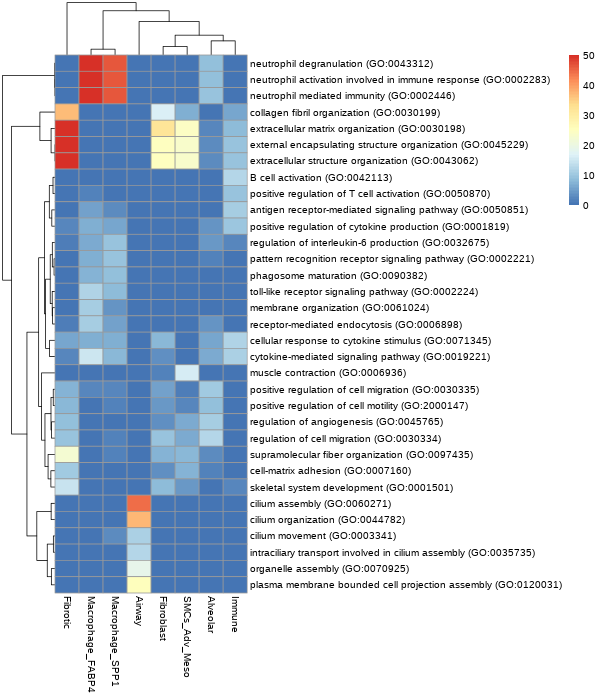

In [447]:
%%R -w 600 -h 700 -i gsea_table_new_cm
p<-pheatmap(gsea_table_new_cm,)

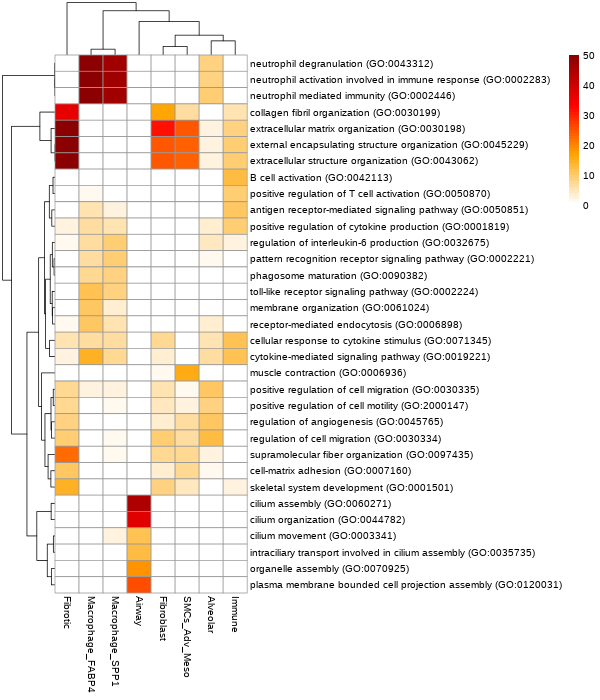

In [448]:
%%R -w 600 -h 700 -i gsea_table_new_cm
my_col <- colorRampPalette(c("white","orange", "red","darkred"))(50)
my_col[0] <- "white"
p<-pheatmap(gsea_table_new_cm, color= my_col)

In [449]:
%%R
pdf("./figures/gsea_table_new_cm_color.pdf") # width = 6, height = 12
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

png 
  2 


# again but now for MSig

In [ ]:
'MSigDB_Hallmark_2020'

In [271]:
#?gseapy.enrichr
for i in adata_vis.obs.Niche_NMF.cat.categories:
    genelist = sc.get.rank_genes_groups_df(adata_vis, group=i, 
                                     log2fc_min=0.5, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
    enr_res = gseapy.enrichr(gene_list=genelist,
                     organism='Human',
                     background=adata_vis.var_names,
                     gene_sets='MSigDB_Hallmark_2020',
                     cutoff = 0.05,)
    enr_res.results["Niche"] = "%s" %i
    enr_res.results= enr_res.results[enr_res.results["Adjusted P-value"] <0.05]
    #enr_res.results=  enr_res.results.nsmallest(n=5, columns=['Adjusted P-value'],keep="all")
    enr_res.results.to_csv("./MSigDB_enrichment/MSigDB_Hallmark_2020_enrichment_%s.txt" %i, sep = "\t", index = False)

In [272]:
gsea_res = pd.concat([pd.read_csv("./MSigDB_enrichment/MSigDB_Hallmark_2020_enrichment_%s.txt" %i,sep = "\t")for i in adata_vis.obs.Niche_NMF.cat.categories], axis = 0)

In [273]:
gsea_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Niche
0,MSigDB_Hallmark_2020,Estrogen Response Early,72/200,4.491975e-13,2.245987e-11,0,0,3.157440,89.770164,KCNK5;LAD1;WWC1;FHL2;SLC2A1;ABAT;CELSR1;AQP3;P...,Airway
1,MSigDB_Hallmark_2020,Estrogen Response Late,71/200,1.420805e-12,3.552011e-11,0,0,3.088235,84.246424,KCNK5;ST6GALNAC2;LAMC2;PRSS23;CXCL14;CDC20;FAM...,Airway
2,MSigDB_Hallmark_2020,Glycolysis,54/200,1.450667e-05,2.417779e-04,0,0,2.061507,22.967051,HS6ST2;GMPPB;NSDHL;CAPN5;SOX9;IL13RA1;CHST6;GL...,Airway
3,MSigDB_Hallmark_2020,Pperoxisome,32/104,5.362391e-05,6.702989e-04,0,0,2.470080,24.289568,ABCD3;CRABP2;SEMA3C;PEX11A;ECI2;IDE;SERPINA6;P...,Airway
4,MSigDB_Hallmark_2020,Bile Acid Metabolism,33/112,1.063370e-04,1.063370e-03,0,0,2.321364,21.237917,ABCD3;SLC23A1;PEX11A;CROT;TFCP2L1;SERPINA6;PRD...,Airway
...,...,...,...,...,...,...,...,...,...,...,...
12,MSigDB_Hallmark_2020,Complement,17/200,4.218289e-03,1.557522e-02,0,0,2.166741,11.848443,DGKG;CFH;F10;C1S;ACTN2;CPQ;C1R;CLU;C3;F8;COL4A...,SMCs_Adv_Meso
13,MSigDB_Hallmark_2020,Mitotic Spindle,16/199,9.068681e-03,2.847136e-02,0,0,2.036783,9.578845,GSN;ROCK1;SORBS2;PKD2;NET1;ARHGAP10;MYO1E;CLIP...,SMCs_Adv_Meso
14,MSigDB_Hallmark_2020,Adipogenesis,16/200,9.490455e-03,2.847136e-02,0,0,2.025607,9.434201,ITIH5;COL15A1;CAVIN1;HSPB8;OMD;PTGER3;VEGFB;SO...,SMCs_Adv_Meso
15,MSigDB_Hallmark_2020,Glycolysis,16/200,9.490455e-03,2.847136e-02,0,0,2.025607,9.434201,PYGB;SDC2;AGL;IGFBP3;AK4;CACNA1H;DCN;NT5E;VCAN...,SMCs_Adv_Meso


In [357]:
gsea_table_new = gsea_res[gsea_res["Term"].isin(gsea_table["Term"])] 
gsea_table_new

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Niche
0,MSigDB_Hallmark_2020,Estrogen Response Early,72/200,4.491975e-13,2.245987e-11,0,0,3.157440,89.770164,KCNK5;LAD1;WWC1;FHL2;SLC2A1;ABAT;CELSR1;AQP3;P...,Airway
1,MSigDB_Hallmark_2020,Estrogen Response Late,71/200,1.420805e-12,3.552011e-11,0,0,3.088235,84.246424,KCNK5;ST6GALNAC2;LAMC2;PRSS23;CXCL14;CDC20;FAM...,Airway
2,MSigDB_Hallmark_2020,Glycolysis,54/200,1.450667e-05,2.417779e-04,0,0,2.061507,22.967051,HS6ST2;GMPPB;NSDHL;CAPN5;SOX9;IL13RA1;CHST6;GL...,Airway
3,MSigDB_Hallmark_2020,Pperoxisome,32/104,5.362391e-05,6.702989e-04,0,0,2.470080,24.289568,ABCD3;CRABP2;SEMA3C;PEX11A;ECI2;IDE;SERPINA6;P...,Airway
4,MSigDB_Hallmark_2020,Bile Acid Metabolism,33/112,1.063370e-04,1.063370e-03,0,0,2.321364,21.237917,ABCD3;SLC23A1;PEX11A;CROT;TFCP2L1;SERPINA6;PRD...,Airway
...,...,...,...,...,...,...,...,...,...,...,...
7,MSigDB_Hallmark_2020,Coagulation,20/138,1.109739e-06,6.658432e-06,0,0,3.981483,54.591656,CFD;GSN;CFH;C1S;F10;CPQ;C1R;ITGB3;MMP2;HTRA1;G...,SMCs_Adv_Meso
8,MSigDB_Hallmark_2020,Estrogen Response Late,23/200,1.024862e-05,5.465930e-05,0,0,3.054316,35.089100,CA12;FOXC1;SLC16A1;SLC24A3;IGFBP4;HSPB8;HSPA4L...,SMCs_Adv_Meso
12,MSigDB_Hallmark_2020,Complement,17/200,4.218289e-03,1.557522e-02,0,0,2.166741,11.848443,DGKG;CFH;F10;C1S;ACTN2;CPQ;C1R;CLU;C3;F8;COL4A...,SMCs_Adv_Meso
14,MSigDB_Hallmark_2020,Adipogenesis,16/200,9.490455e-03,2.847136e-02,0,0,2.025607,9.434201,ITIH5;COL15A1;CAVIN1;HSPB8;OMD;PTGER3;VEGFB;SO...,SMCs_Adv_Meso


In [358]:
gsea_table_new = gsea_table_new.drop(["Gene_set","Overlap","P-value","Old P-value","Old Adjusted P-value","Odds Ratio","Genes","Combined Score"], axis=1)
gsea_table_new

,Term,Adjusted P-value,Niche
0,Estrogen Response Early,2.245987e-11,Airway
1,Estrogen Response Late,3.552011e-11,Airway
2,Glycolysis,2.417779e-04,Airway
3,Pperoxisome,6.702989e-04,Airway
4,Bile Acid Metabolism,1.063370e-03,Airway
...,...,...,...
7,Coagulation,6.658432e-06,SMCs_Adv_Meso
8,Estrogen Response Late,5.465930e-05,SMCs_Adv_Meso
12,Complement,1.557522e-02,SMCs_Adv_Meso
14,Adipogenesis,2.847136e-02,SMCs_Adv_Meso


In [359]:
#gsea_table_new = gsea_table_new[gsea_table_new["Niche"] != "no tissue"] 
#gsea_table_new

In [360]:
gsea_table_new["Adjusted P-value"] = np.log10(gsea_table_new["Adjusted P-value"])
gsea_table_new

,Term,Adjusted P-value,Niche
0,Estrogen Response Early,-10.648593,Airway
1,Estrogen Response Late,-10.449526,Airway
2,Glycolysis,-3.616583,Airway
3,Pperoxisome,-3.173732,Airway
4,Bile Acid Metabolism,-2.973315,Airway
...,...,...,...
7,Coagulation,-5.176628,SMCs_Adv_Meso
8,Estrogen Response Late,-4.262336,SMCs_Adv_Meso
12,Complement,-1.807566,SMCs_Adv_Meso
14,Adipogenesis,-1.545592,SMCs_Adv_Meso


In [361]:
gsea_table_new["Adjusted P-value"] = gsea_table_new["Adjusted P-value"]*(-1)
gsea_table_new

,Term,Adjusted P-value,Niche
0,Estrogen Response Early,10.648593,Airway
1,Estrogen Response Late,10.449526,Airway
2,Glycolysis,3.616583,Airway
3,Pperoxisome,3.173732,Airway
4,Bile Acid Metabolism,2.973315,Airway
...,...,...,...
7,Coagulation,5.176628,SMCs_Adv_Meso
8,Estrogen Response Late,4.262336,SMCs_Adv_Meso
12,Complement,1.807566,SMCs_Adv_Meso
14,Adipogenesis,1.545592,SMCs_Adv_Meso


In [362]:
gsea_table_new['Adjusted P-value'].values[gsea_table_new['Adjusted P-value'] > 55] = 55

In [363]:
gsea_table_new.sort_values(by=["Adjusted P-value"])
gsea_table_new

,Term,Adjusted P-value,Niche
0,Estrogen Response Early,10.648593,Airway
1,Estrogen Response Late,10.449526,Airway
2,Glycolysis,3.616583,Airway
3,Pperoxisome,3.173732,Airway
4,Bile Acid Metabolism,2.973315,Airway
...,...,...,...
7,Coagulation,5.176628,SMCs_Adv_Meso
8,Estrogen Response Late,4.262336,SMCs_Adv_Meso
12,Complement,1.807566,SMCs_Adv_Meso
14,Adipogenesis,1.545592,SMCs_Adv_Meso


In [373]:
gsea_table_new_cm= pd.pivot(gsea_table_new,index="Term", columns="Niche", values="Adjusted P-value")
gsea_table_new_cm = gsea_table_new_cm.fillna(0)

In [374]:
gsea_table_new_cm

Niche,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Term,,,,,,,,
Adipogenesis,0.000000,2.297616,3.646307,0.000000,0.000000,21.416255,4.774304,1.545592
Allograft Rejection,0.000000,2.887054,1.664754,2.232504,19.153086,10.035782,12.118128,0.000000
Apical Junction,0.000000,8.360010,4.476818,8.019744,0.000000,0.000000,0.000000,8.535552
Bile Acid Metabolism,2.973315,0.000000,0.000000,0.000000,0.000000,2.307297,1.856956,0.000000
Coagulation,0.000000,1.952758,9.069688,10.327602,0.000000,2.155327,2.193359,5.176628
Complement,0.000000,3.887523,2.932055,5.203109,3.399415,14.951010,12.512173,1.807566
Epithelial Mesenchymal Transition,0.000000,0.000000,43.484240,55.000000,5.462021,0.000000,2.013188,50.399850
Estrogen Response Early,10.648593,5.953179,4.053458,5.203109,1.658289,2.639919,2.238668,7.991618
Estrogen Response Late,10.449526,7.889077,0.000000,2.566991,1.658289,3.854080,6.276032,4.262336


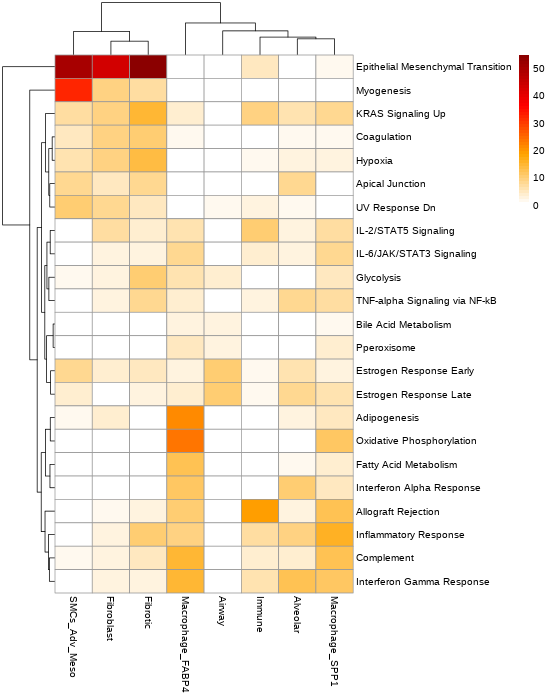

In [402]:
%%R -w 550 -h 700 -i gsea_table_new_cm
my_col <- colorRampPalette(c("white","orange", "red","darkred"))(50)
my_col[0] <- "white"
p<-pheatmap(gsea_table_new_cm, color= my_col)

In [403]:
%%R
pdf("./figures/MsigDB_table_new_cm_color.pdf") # width = 6, height = 12
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

png 
  2 
